# 03 - Modelado: Feature Engineering, ML y Evaluación

**Objetivo:** Predecir la **inflación mensual** (cambio % del CPI), no el valor absoluto del CPI.

**Input:** `data/processed/dataset_modelo.csv`

**Output:** Modelo entrenado y métricas de evaluación

## 1. Setup

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
import mlflow.sklearn

# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# Directorio
os.chdir("/Users/javiermondragon/Documents/data_projects/inflation-predictor")

print("Setup completo")

Setup completo


In [2]:
# Cargar datos
df = pd.read_csv('data/processed/dataset_modelo.csv', parse_dates=['date'])

print(f"Dataset cargado: {len(df)} filas")
print(f"Período: {df['date'].min().strftime('%Y-%m')} a {df['date'].max().strftime('%Y-%m')}")
df.head()

Dataset cargado: 479 filas
Período: 1986-01 a 2025-12


,date,cpi,fed_rate,oil_price,gold_price
0,1986-01-01,109.9,8.14,22.925455,347.48
1,1986-02-01,109.7,7.86,15.454737,338.89
2,1986-03-01,109.1,7.48,12.612500,345.70
3,1986-04-01,108.7,6.99,12.843636,340.44
4,1986-05-01,109.0,6.85,15.377619,342.40


## 2. Feature Engineering

### 2.1 Crear el Target: Inflación Mensual

In [3]:
# El target es la inflación (cambio % del CPI mes a mes)
df['inflation'] = df['cpi'].pct_change() * 100

print("Target creado: inflation (cambio % mensual del CPI)")
print(f"\nEstadísticas de inflación mensual:")
print(f"  Media: {df['inflation'].mean():.3f}%")
print(f"  Std: {df['inflation'].std():.3f}%")
print(f"  Min: {df['inflation'].min():.3f}%")
print(f"  Max: {df['inflation'].max():.3f}%")

Target creado: inflation (cambio % mensual del CPI)

Estadísticas de inflación mensual:
  Media: 0.228%
  Std: 0.267%
  Min: -1.771%
  Max: 1.377%


### 2.2 Lags de las variables predictoras (NO del CPI)

In [4]:
# Solo crear lags para las variables predictoras, NO para CPI
# Esto evita data leakage
predictores = ['fed_rate', 'oil_price', 'gold_price']
lags = [1, 3, 6, 12]

for var in predictores:
    for lag in lags:
        df[f'{var}_lag{lag}'] = df[var].shift(lag)

print(f"Lags creados: {len(lags)} por cada {len(predictores)} variables = {len(lags)*len(predictores)} features")

Lags creados: 4 por cada 3 variables = 12 features


### 2.3 Lags de la inflación pasada

In [5]:
# Sí podemos usar la inflación PASADA como feature
# (inflación del mes pasado para predecir la de este mes)
for lag in lags:
    df[f'inflation_lag{lag}'] = df['inflation'].shift(lag)

print(f"Lags de inflación creados: {len(lags)} features")

Lags de inflación creados: 4 features


### 2.4 Promedios Móviles

In [6]:
# Promedios móviles solo para predictores
ventanas = [3, 6, 12]

for var in predictores:
    for ventana in ventanas:
        df[f'{var}_ma{ventana}'] = df[var].rolling(window=ventana).mean()

# También para inflación pasada
for ventana in ventanas:
    df[f'inflation_ma{ventana}'] = df['inflation'].shift(1).rolling(window=ventana).mean()

print(f"Promedios móviles creados")

Promedios móviles creados


### 2.5 Variaciones Porcentuales

In [7]:
# Variaciones porcentuales de los predictores
for var in predictores:
    df[f'{var}_pct_1m'] = df[var].pct_change(1) * 100
    df[f'{var}_pct_12m'] = df[var].pct_change(12) * 100

print(f"Variaciones porcentuales creadas")

Variaciones porcentuales creadas


### 2.6 Features Temporales

In [8]:
# Features de fecha
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

print("Features temporales creados: year, month, quarter")

Features temporales creados: year, month, quarter


In [9]:
# Ver todas las columnas
print(f"\nTOTAL DE COLUMNAS: {len(df.columns)}")
print(f"\nColumnas:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")


TOTAL DE COLUMNAS: 43

Columnas:
  1. date
  2. cpi
  3. fed_rate
  4. oil_price
  5. gold_price
  6. inflation
  7. fed_rate_lag1
  8. fed_rate_lag3
  9. fed_rate_lag6
  10. fed_rate_lag12
  11. oil_price_lag1
  12. oil_price_lag3
  13. oil_price_lag6
  14. oil_price_lag12
  15. gold_price_lag1
  16. gold_price_lag3
  17. gold_price_lag6
  18. gold_price_lag12
  19. inflation_lag1
  20. inflation_lag3
  21. inflation_lag6
  22. inflation_lag12
  23. fed_rate_ma3
  24. fed_rate_ma6
  25. fed_rate_ma12
  26. oil_price_ma3
  27. oil_price_ma6
  28. oil_price_ma12
  29. gold_price_ma3
  30. gold_price_ma6
  31. gold_price_ma12
  32. inflation_ma3
  33. inflation_ma6
  34. inflation_ma12
  35. fed_rate_pct_1m
  36. fed_rate_pct_12m
  37. oil_price_pct_1m
  38. oil_price_pct_12m
  39. gold_price_pct_1m
  40. gold_price_pct_12m
  41. year
  42. month
  43. quarter


### 2.7 Eliminar Filas con NaN

In [10]:
# Los lags y MA crean NaN al inicio
print(f"Filas antes: {len(df)}")
print(f"Filas con NaN: {df.isna().any(axis=1).sum()}")

df_clean = df.dropna().reset_index(drop=True)

print(f"Filas después: {len(df_clean)}")
print(f"Período: {df_clean['date'].min().strftime('%Y-%m')} a {df_clean['date'].max().strftime('%Y-%m')}")

Filas antes: 479
Filas con NaN: 13
Filas después: 466
Período: 1987-02 a 2025-12


## 3. Preparar Datos para Modelo

In [11]:
# Definir target y features
target = 'inflation'  # Predecimos inflación, NO el CPI

# Excluir: date, target, CPI (para evitar leakage)
excluir = ['date', 'cpi', 'inflation']

features = [col for col in df_clean.columns if col not in excluir]

print(f"Target: {target}")
print(f"Features: {len(features)}")
print(f"\nLista de features:")
for f in features:
    print(f"  - {f}")

Target: inflation
Features: 40

Lista de features:
  - fed_rate
  - oil_price
  - gold_price
  - fed_rate_lag1
  - fed_rate_lag3
  - fed_rate_lag6
  - fed_rate_lag12
  - oil_price_lag1
  - oil_price_lag3
  - oil_price_lag6
  - oil_price_lag12
  - gold_price_lag1
  - gold_price_lag3
  - gold_price_lag6
  - gold_price_lag12
  - inflation_lag1
  - inflation_lag3
  - inflation_lag6
  - inflation_lag12
  - fed_rate_ma3
  - fed_rate_ma6
  - fed_rate_ma12
  - oil_price_ma3
  - oil_price_ma6
  - oil_price_ma12
  - gold_price_ma3
  - gold_price_ma6
  - gold_price_ma12
  - inflation_ma3
  - inflation_ma6
  - inflation_ma12
  - fed_rate_pct_1m
  - fed_rate_pct_12m
  - oil_price_pct_1m
  - oil_price_pct_12m
  - gold_price_pct_1m
  - gold_price_pct_12m
  - year
  - month
  - quarter


In [12]:
# Verificar que no hay leakage
print("Verificando que no hay features de CPI (excepto inflación pasada):")
cpi_features = [f for f in features if 'cpi' in f.lower()]
if len(cpi_features) == 0:
    print("  ✓ No hay features de CPI")
else:
    print(f"  ✗ Features con CPI: {cpi_features}")

Verificando que no hay features de CPI (excepto inflación pasada):
  ✓ No hay features de CPI


In [13]:
# Crear X e y
X = df_clean[features]
y = df_clean[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nTarget (inflación) stats:")
print(f"  Media: {y.mean():.4f}%")
print(f"  Std: {y.std():.4f}%")

X shape: (466, 40)
y shape: (466,)

Target (inflación) stats:
  Media: 0.2311%
  Std: 0.2649%


## 4. Train/Test Split (Temporal)

In [14]:
# Split temporal: 80% train, 20% test
split_idx = int(len(df_clean) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

dates_train = df_clean['date'].iloc[:split_idx]
dates_test = df_clean['date'].iloc[split_idx:]

print(f"Train: {len(X_train)} filas ({dates_train.min().strftime('%Y-%m')} a {dates_train.max().strftime('%Y-%m')})")
print(f"Test: {len(X_test)} filas ({dates_test.min().strftime('%Y-%m')} a {dates_test.max().strftime('%Y-%m')})")

Train: 372 filas (1987-02 a 2018-01)
Test: 94 filas (2018-02 a 2025-12)


In [15]:
# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features escalados")

Features escalados


## 5. Entrenar Modelos

In [16]:
# Definir modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'SVR': SVR(kernel='rbf', C=10, epsilon=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print(f"Modelos a entrenar: {len(modelos)}")

Modelos a entrenar: 6


In [17]:
# Función de evaluación
def evaluar_modelo(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

In [18]:
# Entrenar y evaluar cada modelo
resultados = []
predicciones = {}

print("Entrenando modelos...\n")
print(f"{'Modelo':<25} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-" * 60)

for nombre, modelo in modelos.items():
    # Usar datos escalados para SVR, originales para el resto
    if nombre == 'SVR':
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    
    # Evaluar
    metricas = evaluar_modelo(y_test, y_pred)
    metricas['modelo'] = nombre
    resultados.append(metricas)
    predicciones[nombre] = y_pred
    
    print(f"{nombre:<25} {metricas['RMSE']:>10.4f} {metricas['MAE']:>10.4f} {metricas['R2']:>10.4f}")

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados[['modelo', 'RMSE', 'MAE', 'R2']].sort_values('RMSE')

Entrenando modelos...

Modelo                          RMSE        MAE         R²
------------------------------------------------------------
Linear Regression             0.4633     0.2807    -1.6224
Ridge                         0.4964     0.2941    -2.0095
Lasso                         0.3632     0.2416    -0.6117
SVR                           0.4046     0.3026    -1.0000


/Users/javiermondragon/Documents/data_projects/inflation-predictor/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.202e+00, tolerance: 2.455e-03
  model = cd_fast.enet_coordinate_descent(


Random Forest                 0.2087     0.1533     0.4678
Gradient Boosting             0.2627     0.1783     0.1568


## 6. Comparación de Modelos

In [19]:
# Tabla de resultados
print("\nRANKING DE MODELOS (por RMSE)")
print("=" * 60)
df_resultados


RANKING DE MODELOS (por RMSE)


,modelo,RMSE,MAE,R2
4,Random Forest,0.208727,0.153278,0.467815
5,Gradient Boosting,0.262733,0.178297,0.156792
2,Lasso,0.363239,0.241568,-0.611725
3,SVR,0.404634,0.302614,-0.999999
0,Linear Regression,0.463337,0.280677,-1.622406
1,Ridge,0.496356,0.294139,-2.009488


In [20]:
# Seleccionar mejor modelo
mejor_modelo = df_resultados.iloc[0]['modelo']
print(f"Mejor modelo: {mejor_modelo}")

Mejor modelo: Random Forest


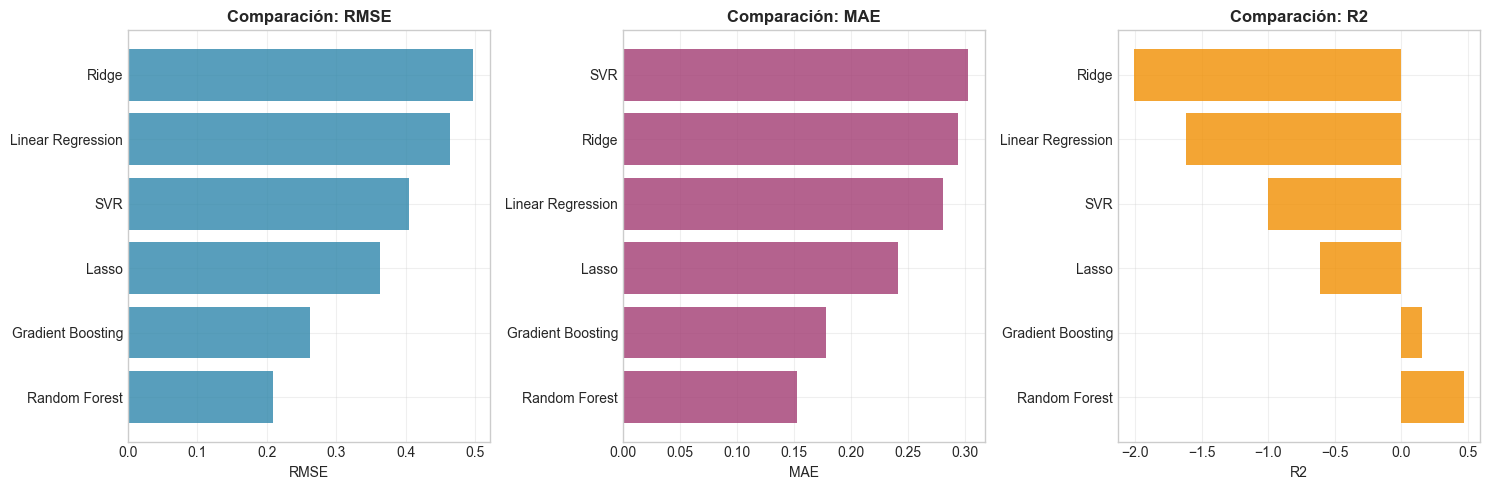

In [ ]:
# Gráfico de comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metricas_plot = ['RMSE', 'MAE', 'R2']
colores = ['#2E86AB', '#A23B72', '#F18F01']

for ax, metrica, color in zip(axes, metricas_plot, colores):
    df_sorted = df_resultados.sort_values(metrica, ascending=(metrica != 'R2'))
    ax.barh(df_sorted['modelo'], df_sorted[metrica], color=color, alpha=0.8)
    ax.set_xlabel(metrica)
    ax.set_title(f'Comparación: {metrica}', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/processed/modelo_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Visualizar Predicciones

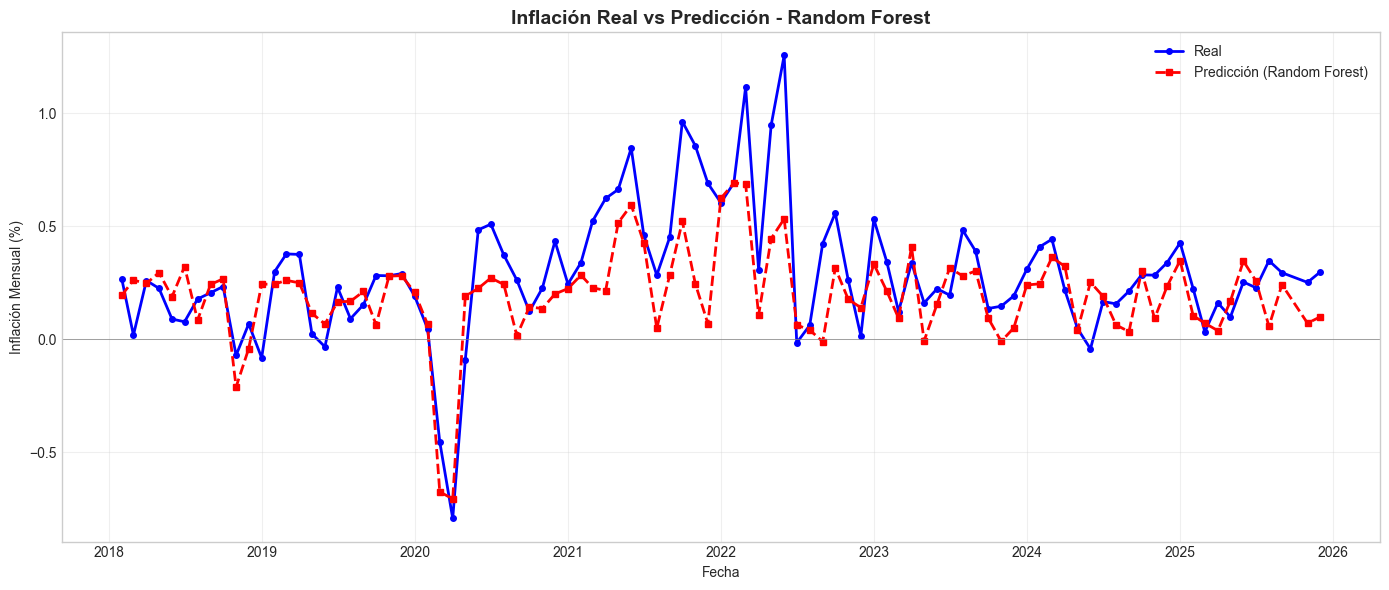

In [ ]:
# Gráfico: Inflación Real vs Predicción
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dates_test, y_test.values, 'b-', linewidth=2, label='Real', marker='o', markersize=4)
ax.plot(dates_test, predicciones[mejor_modelo], 'r--', linewidth=2, label=f'Predicción ({mejor_modelo})', marker='s', markersize=4)

ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('Fecha')
ax.set_ylabel('Inflación Mensual (%)')
ax.set_title(f'Inflación Real vs Predicción - {mejor_modelo}', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/processed/modelo_prediccion.png', dpi=150, bbox_inches='tight')
plt.show()

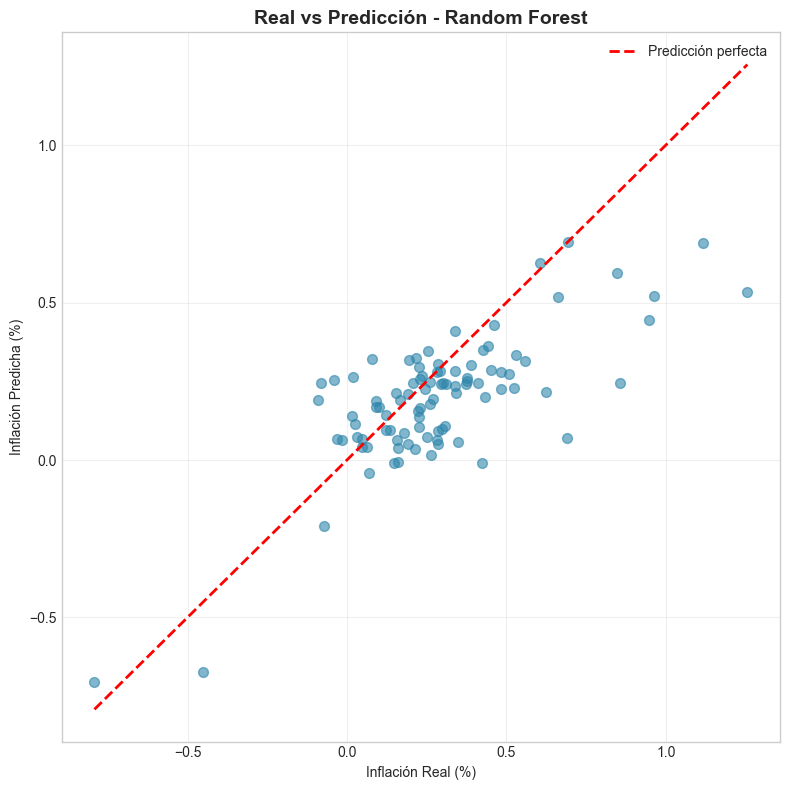

In [ ]:
# Scatter: Real vs Predicción
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test, predicciones[mejor_modelo], alpha=0.6, s=50, c='#2E86AB')

# Línea perfecta
min_val = min(y_test.min(), min(predicciones[mejor_modelo]))
max_val = max(y_test.max(), max(predicciones[mejor_modelo]))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

ax.set_xlabel('Inflación Real (%)')
ax.set_ylabel('Inflación Predicha (%)')
ax.set_title(f'Real vs Predicción - {mejor_modelo}', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/processed/modelo_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Análisis de Errores

In [24]:
# Calcular errores
errores = y_test.values - predicciones[mejor_modelo]

print("ANÁLISIS DE ERRORES")
print("=" * 40)
print(f"Media del error: {errores.mean():.4f}")
print(f"Std del error: {errores.std():.4f}")
print(f"Error máximo: {errores.max():.4f}")
print(f"Error mínimo: {errores.min():.4f}")

ANÁLISIS DE ERRORES
Media del error: 0.0918
Std del error: 0.1874
Error máximo: 0.7231
Error mínimo: -0.3256


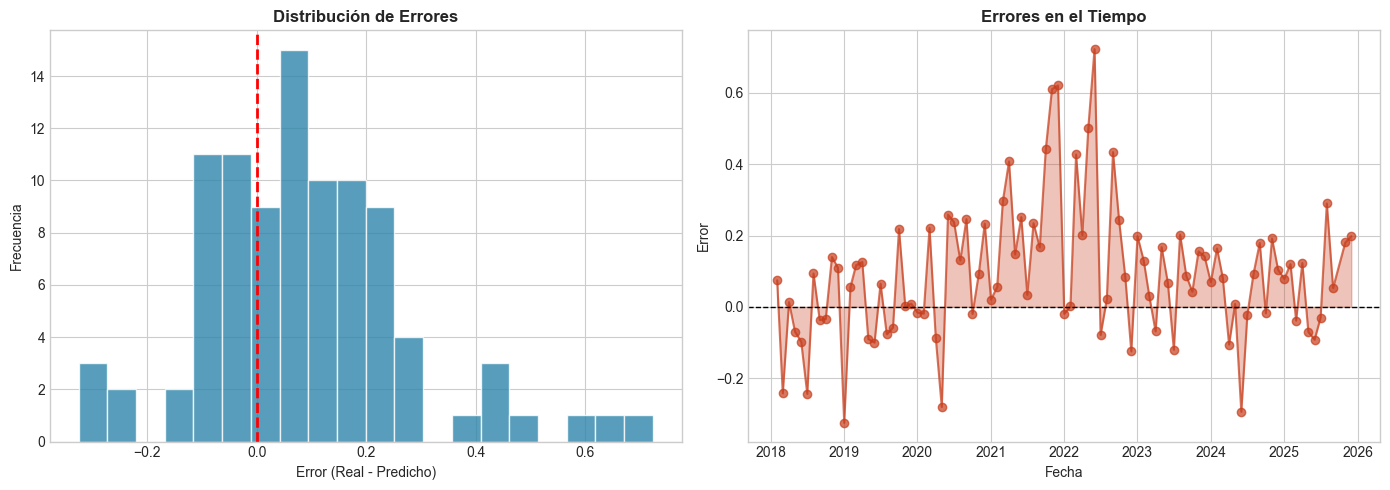

In [ ]:
# Distribución de errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(errores, bins=20, color='#2E86AB', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (Real - Predicho)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Errores', fontweight='bold')

# Errores en el tiempo
axes[1].plot(dates_test, errores, 'o-', color='#C73E1D', alpha=0.7)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(dates_test, errores, alpha=0.3, color='#C73E1D')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Error')
axes[1].set_title('Errores en el Tiempo', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/processed/modelo_errores.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Importancia de Features

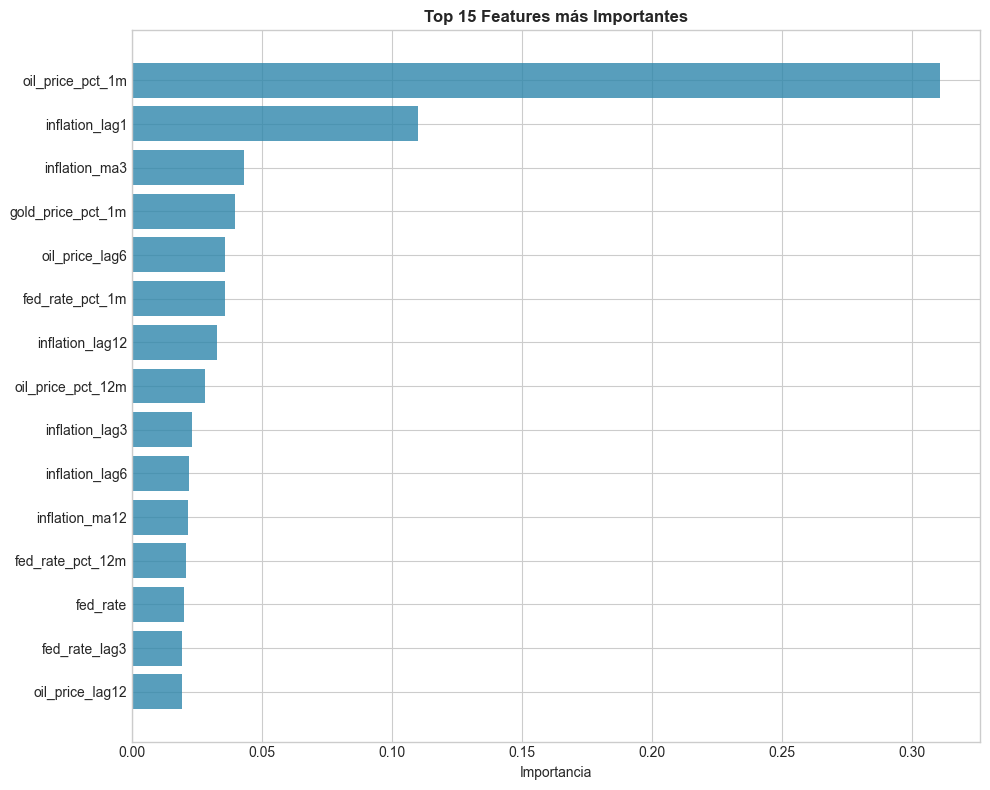


Top 10 Features:
          feature  importance
 oil_price_pct_1m    0.310774
   inflation_lag1    0.109940
    inflation_ma3    0.043056
gold_price_pct_1m    0.039621
   oil_price_lag6    0.035865
  fed_rate_pct_1m    0.035818
  inflation_lag12    0.032596
oil_price_pct_12m    0.028084
   inflation_lag3    0.022879
   inflation_lag6    0.021737


In [ ]:
# Para Random Forest o Gradient Boosting
if mejor_modelo in ['Random Forest', 'Gradient Boosting']:
    modelo_final = modelos[mejor_modelo]
    importancias = pd.DataFrame({
        'feature': features,
        'importance': modelo_final.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    # Usar Random Forest para ver importancia de features
    rf_temp = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_temp.fit(X_train, y_train)
    importancias = pd.DataFrame({
        'feature': features,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)

# Top 15
top_15 = importancias.head(15)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_15['feature'], top_15['importance'], color='#2E86AB', alpha=0.8)
ax.set_xlabel('Importancia')
ax.set_title('Top 15 Features más Importantes', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/processed/modelo_importancia.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(importancias.head(10).to_string(index=False))

## 10. Baseline: Comparar con modelo naive

In [27]:
# Baseline: Predecir que la inflación de este mes = inflación del mes pasado
y_baseline = df_clean['inflation'].shift(1).iloc[split_idx:].values

metricas_baseline = evaluar_modelo(y_test, y_baseline)

print("COMPARACIÓN CON BASELINE (inflación mes anterior)")
print("=" * 60)
print(f"{'Modelo':<25} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-" * 60)
print(f"{'Baseline (lag 1)':<25} {metricas_baseline['RMSE']:>10.4f} {metricas_baseline['MAE']:>10.4f} {metricas_baseline['R2']:>10.4f}")
print(f"{mejor_modelo:<25} {df_resultados.iloc[0]['RMSE']:>10.4f} {df_resultados.iloc[0]['MAE']:>10.4f} {df_resultados.iloc[0]['R2']:>10.4f}")

mejora_rmse = (metricas_baseline['RMSE'] - df_resultados.iloc[0]['RMSE']) / metricas_baseline['RMSE'] * 100
print(f"\nMejora sobre baseline: {mejora_rmse:.1f}% en RMSE")

COMPARACIÓN CON BASELINE (inflación mes anterior)
Modelo                          RMSE        MAE         R²
------------------------------------------------------------
Baseline (lag 1)              0.2697     0.1866     0.1117
Random Forest                 0.2087     0.1533     0.4678

Mejora sobre baseline: 22.6% en RMSE


## 11. Guardar Modelo

In [28]:
import joblib

# Crear carpeta
os.makedirs('models', exist_ok=True)

# Guardar mejor modelo
modelo_final = modelos[mejor_modelo]
joblib.dump(modelo_final, f'models/{mejor_modelo.lower().replace(" ", "_")}.joblib')

# Guardar scaler
joblib.dump(scaler, 'models/scaler.joblib')

# Guardar lista de features
pd.Series(features).to_csv('models/features.csv', index=False)

print(f"✓ Modelo guardado: models/{mejor_modelo.lower().replace(' ', '_')}.joblib")
print(f"✓ Scaler guardado: models/scaler.joblib")
print(f"✓ Features guardados: models/features.csv")

✓ Modelo guardado: models/random_forest.joblib
✓ Scaler guardado: models/scaler.joblib
✓ Features guardados: models/features.csv


## 12. Resumen Final

In [29]:
print("="*60)
print("RESUMEN DEL MODELADO")
print("="*60)

print(f"\n1. TARGET: Inflación mensual (cambio % del CPI)")

print(f"\n2. DATOS:")
print(f"   - Observaciones: {len(df_clean)}")
print(f"   - Features: {len(features)}")
print(f"   - Train: {len(X_train)} | Test: {len(X_test)}")

print(f"\n3. MEJOR MODELO: {mejor_modelo}")
best_metrics = df_resultados.iloc[0]
print(f"   - RMSE: {best_metrics['RMSE']:.4f}")
print(f"   - MAE: {best_metrics['MAE']:.4f}")
print(f"   - R²: {best_metrics['R2']:.4f}")

print(f"\n4. INTERPRETACIÓN:")
print(f"   - El modelo predice la inflación mensual con un error promedio de {best_metrics['MAE']:.3f}%")
print(f"   - Eso significa que si la inflación real es 0.5%, el modelo podría predecir entre {0.5-best_metrics['MAE']:.3f}% y {0.5+best_metrics['MAE']:.3f}%")

RESUMEN DEL MODELADO

1. TARGET: Inflación mensual (cambio % del CPI)

2. DATOS:
   - Observaciones: 466
   - Features: 40
   - Train: 372 | Test: 94

3. MEJOR MODELO: Random Forest
   - RMSE: 0.2087
   - MAE: 0.1533
   - R²: 0.4678

4. INTERPRETACIÓN:
   - El modelo predice la inflación mensual con un error promedio de 0.153%
   - Eso significa que si la inflación real es 0.5%, el modelo podría predecir entre 0.347% y 0.653%


## Próximos Pasos

1. **MLflow:** Trackear experimentos
2. **Walk-forward validation:** Validación más rigurosa
3. **Hyperparameter tuning:** Optimizar parámetros
4. **Deploy:** Subir a AWS